In [0]:
# !pip install pyspark
from pyspark import SparkContext, SparkConf 
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import lit
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
import re
import string
from pyspark.ml.feature import (CountVectorizer, Tokenizer,StopWordsRemover, IDF, StringIndexer)

# !pip install nltk
from pyspark.sql.types import ArrayType, FloatType, StringType
from nltk import ngrams

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

In [0]:
# !pip install spark

# from pyspark.context import SparkContext
# from pyspark.sql.session import SparkSession
# sc = SparkContext('local')
# spark = SparkSession(sc)

In [0]:
df_test = spark.read.csv("dbfs:/FileStore/shared_uploads/amirabbas.abbaspourm@ucalgary.ca/df_test.csv"
                         , header="true", multiLine="true", escape="\"", sep=',', inferSchema=True)
df_train = spark.read.csv("dbfs:/FileStore/shared_uploads/amirabbas.abbaspourm@ucalgary.ca/df_train.csv"
                          , header="true", multiLine="true", escape="\"", sep=',', inferSchema=True)
df_test_AAM = spark.read.csv("dbfs:/FileStore/shared_uploads/amirabbas.abbaspourm@ucalgary.ca/Amir_Ali_Misagh.csv"
                             , header="true", multiLine="true", escape="\"", sep=',', inferSchema=True)

In [0]:
df_train = df_train.sample(0.15, seed=101)

In [0]:
char_map = [
    ('    ', ' JJJquadspace '),
    ('  ', ' JJJdoublespace '),
    ('\n', ' JJJendline \n JJJnewline '),
    ('\t', ' JJJtabulator '),
    ('~', ' JJJtilde '),
    ('!', ' JJJexclamation '),
    ('@', ' JJJat '),
    ('####', ' JJJquadhash '),
    ('###', ' JJJtriplehash '),
    ('##', ' JJJdoublehash '),
    ('#', ' JJJsinglehash '),
    ('$', ' JJJdollar '),
    ('%', ' JJJpercent '),
    ('^', ' JJJhat '),
    ('&', ' JJJampersand '),
    ('*', ' JJJasterisk '),
    ('(', ' JJJroundbracketopen '),
    (')', ' JJJroundbracketclose '),
    ('_', ' JJJunderscore '),
    ('-', ' JJJminus '),
    ('=', ' JJJequals '),
    ('+', ' JJJplus '),
    ('[', ' JJJsqarebracketopen '),
    (']', ' JJJsqarebracketclose '),
    ('{', ' JJJcurlybracketopen '),
    ('}', ' JJJcurlybracketclose '),
    (';', ' JJJsemicolon '),
    (':', ' JJJcolon '),
    ("'", ' JJJsinglequote '),
    ('"', ' JJJquote '),
    ('\\', ' JJJbackslash '),
    ('|', ' JJJpipe '),
    (',', ' JJJcomma '),
    ('<', ' JJJsmaller '),
    ('.', ' JJJdot '),
    ('>', ' JJJlarger '),
    ('/', ' JJJslash '),
    ('`', ' JJJbacktick '),
    ('?', ' JJJquestion ')]
 
unic_char_map = [
    ('’', ' JJJtick '),
    ('´', ' JJJtick '),
    ('‘', ' JJJtick '),
    ('“', ' JJJsquote '),
    ('”', ' JJJsquote '),
    ('：', ' JJJcolon '),
    ('﹕', ' JJJcolon '),
    ('，', ' JJJcomma '),
    ('…', ' JJJellipsis '),
    ('–', ' JJJminus '),
    ('—', ' JJJminus '),
    ('«', ' JJJpointybracketopen '),
    ('›', ' JJJpointybracketopen '),
    ('»', ' JJJpointybracketclose '),
    ('‹', ' JJJpointybracketclose '),
    ('👉', ' JJJunicodearrow '),
    ('→', ' JJJunicodearrow '),
    ('↓', ' JJJunicodearrow '),
    ('│', ' JJJunicodebox '),
    ('├', ' JJJunicodebox '),
    ('┌', ' JJJunicodebox '),
    ('└', ' JJJunicodebox '),
    ('┤', ' JJJunicodebox '),
    ('┐', ' JJJunicodebox '),
    ('┘', ' JJJunicodebox '),
    ('┬', ' JJJunicodebox '),
    ('─', ' JJJunicodebox '),
    ('║', ' JJJunicodebox '),
    ('╚', ' JJJunicodebox '),
    ('╔', ' JJJunicodebox '),
    ('═', ' JJJunicodebox '),
    ('╗', ' JJJunicodebox '),
    ('╝', ' JJJunicodebox '),
    ('§', ' JJJparagraph '),
    ('·', ' JJJitemize '),
    ('•', ' JJJitemize '),
    ('●', ' JJJitemize '),
    ('✔', ' JJJCheckmark '),
    ('✓', ' JJJCheckmark ')]
 
rec_map = [
    (re.compile(r"(?:(?:[A-Z][a-z0-9]*)+(?:Exception|Error))"), ' JJJexception '),
    (re.compile(r"(?:(?:[A-Z]?[a-z0-9]+)(?:[A-Z][a-z0-9]*)+)"), ' JJJcamelcased '),
    (re.compile(r"(?:(?:\w+_)+\w+)"), ' JJJunderscored '),
    (re.compile(r"(?:0x[a-f0-9]+)"), ' JJJhex '),
    (re.compile(r"\d+"), ' JJJnumber '),
]
 
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pyspark.sql.types as t
import logging as log


@f.udf("String")
def replace_special_char(text):
        for rec in rec_map:
            text = rec[0].sub(rec[1], text)
       # if  repl_all_caps:
        #    text = rec_all_caps[0].sub(rec_all_caps[1], text)
        for repl in char_map:
            text = text.replace(repl[0], repl[1])
        for repl in unic_char_map:
            text = text.replace(repl[0], repl[1])
        return ' JJJnewline ' + text + ' JJJendline '

# spark.udf.register("replace_special_char", replace_special_char)

In [0]:
# spark.udf.register('replace_special_char', replace_special_char)

In [0]:
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline

def build_ngrams(n=3):
    tokenizer = [
      Tokenizer(inputCol = 'processed',
                outputCol = 'token_text')
#       for i in range(1, n + 1)
    ]
    
    ngrams = [
        NGram(n=i, inputCol="token_text",
              outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i))
        for i in range(1, n + 1)
    ]

    assembler = [VectorAssembler(
        inputCols=["{0}_counts".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]

    return Pipeline(stages=tokenizer + ngrams + vectorizers + assembler)

In [0]:
df_trainProcessed = df_train.withColumn("processed", replace_special_char("doc"))
pipeline = build_ngrams()
my_pipeline = pipeline.fit(df_trainProcessed)
transformed_pl = my_pipeline.transform(df_trainProcessed)
train_dataset = transformed_pl.select('target', 'features')
train_dataset = train_dataset.withColumnRenamed('target', 'label')
train_dataset.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(514128,[0,4,5,16...|
|    1|(514128,[0,4,5,16...|
|    1|(514128,[0,4,5,16...|
|    1|(514128,[0,4,5,16...|
|    1|(514128,[0,4,5,13...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,4,5,15...|
|    1|(514128,[0,4,5,22...|
|    1|(514128,[0,4,5,12...|
|    1|(514128,[0,4,5,12...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
+-----+--------------------+
only showing top 20 rows



In [0]:
df_testAAMProcessed = df_test_AAM.withColumn("processed", replace_special_char("doc"))
testAAM_dataset = my_pipeline.transform(df_testAAMProcessed)
testAAM_dataset = testAAM_dataset.select('target', 'features')
testAAM_dataset = testAAM_dataset.withColumnRenamed('target', 'label')
testAAM_dataset.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(514128,[0,1,4,5,...|
|    0|(514128,[0,1,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,4,5,10...|
|    0|(514128,[0,2,4,5,...|
|    0|(514128,[0,1,2,3,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,4,5,10...|
|    0|(514128,[0,1,3,4,...|
|    0|(514128,[0,1,3,4,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,1,3,4,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,1,3,4,...|
|    1|(514128,[0,3,4,5,...|
|    1|(514128,[0,3,4,5,...|
|    1|(514128,[0,4,5,15...|
+-----+--------------------+
only showing top 20 rows



In [0]:
# WARNING TEST SET PIPELINE
# PIPELINE FITTED TO TRAINING SET AND TRANSFORMED TO THE TEST SET

df_testProcessed = df_test.withColumn("processed", replace_special_char("doc"))
test_dataset = my_pipeline.transform(df_testProcessed)
test_dataset = test_dataset.select('target', 'features')
test_dataset = test_dataset.withColumnRenamed('target', 'label')
test_dataset.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,4,5,9,...|
|    1|(514128,[0,4,5,15...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    1|(514128,[0,1,4,5,...|
|    1|(514128,[0,4,5,53...|
|    0|(514128,[0,1,3,4,...|
|    0|(514128,[0,1,2,4,...|
|    0|(514128,[0,2,3,4,...|
|    1|(514128,[0,4,5,6,...|
|    1|(514128,[0,4,5,53...|
|    0|(514128,[0,4,5,11...|
|    0|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,4,5,8,...|
|    1|(514128,[0,3,4,5,...|
+-----+--------------------+
only showing top 20 rows



In [0]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier #, RandomForestClassificationModel

In [0]:
svc_model = LinearSVC()
rfc_model = RandomForestClassifier()

In [0]:
nl_classifier_rfc = rfc_model.fit(train_dataset)

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()

predictions_rfc_default_test = nl_classifier_rfc.transform(test_dataset)
print("RFC:\nTest Accuracy of default test set: " + str(evaluator.evaluate(predictions_rfc_default_test, {evaluator.metricName: "accuracy"})))

RFC:
Test Accuracy of default test set: 0.7781513983433117


In [0]:
predictions_rfc_AAM = nl_classifier_rfc.transform(testAAM_dataset)

print("RFC:\Test Accuracy of Amir, Ali, and Misagh test set: " + str(evaluator.evaluate(predictions_rfc_AAM, {evaluator.metricName: "accuracy"})))

RFC:\Test Accuracy of Amir, Ali, and Misagh test set: 0.8618290258449304


In [0]:
import mlflow.sklearn
from sklearn.utils import parallel_backend
from sklearn.metrics import confusion_matrix
import numpy as np

RFC_test_AAM=confusion_matrix(np.array(testAAM_dataset.select("label").collect()), np.array(predictions_rfc_AAM.select("prediction").collect()))

In [0]:
RFC_test_dflt=confusion_matrix(np.array(test_dataset.select("label").collect()), np.array(predictions_rfc_default_test.select("prediction").collect()))

Out[26]: <matplotlib.axes._subplots.AxesSubplot at 0x7f3e49f66b80>

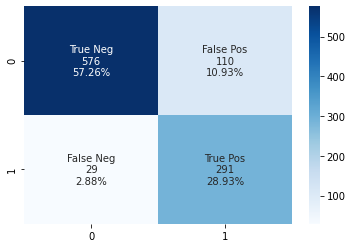

In [0]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                RFC_test_AAM.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     RFC_test_AAM.flatten()/np.sum(RFC_test_AAM)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RFC_test_AAM, annot=labels, fmt="", cmap='Blues')

Out[27]: <matplotlib.axes._subplots.AxesSubplot at 0x7f3e4a3ab4c0>

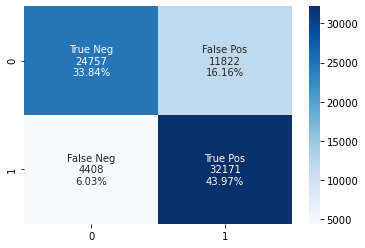

In [0]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                RFC_test_dflt.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     RFC_test_dflt.flatten()/np.sum(RFC_test_dflt)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RFC_test_dflt, annot=labels, fmt="", cmap='Blues')

In [0]:
from sklearn.metrics import classification_report
print("RFC with default test set ")
print(classification_report(np.array(test_dataset.select("label").collect()), np.array(predictions_rfc_default_test.select("prediction").collect())))

RFC with default test set 
              precision    recall  f1-score   support

           0       0.85      0.68      0.75     36579
           1       0.73      0.88      0.80     36579

    accuracy                           0.78     73158
   macro avg       0.79      0.78      0.78     73158
weighted avg       0.79      0.78      0.78     73158



In [0]:
import pandas as pd
print("RFC with AAM test set ")
print(classification_report(testAAM_dataset.select("label").toPandas(), predictions_rfc_AAM.select("prediction").toPandas()))

RFC with AAM test set 
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       686
           1       0.73      0.91      0.81       320

    accuracy                           0.86      1006
   macro avg       0.84      0.87      0.85      1006
weighted avg       0.88      0.86      0.87      1006



In [0]:
nl_classifier_svc = svc_model.fit(train_dataset)

In [0]:
predictions_SVC_default_test = nl_classifier_svc.transform(test_dataset)
print("SVC:\nTest Accuracy of default test set: " + str(evaluator.evaluate(predictions_SVC_default_test,\
                                                 {evaluator.metricName: "accuracy"})))

SVC:
Test Accuracy of default test set: 0.9463079909237541


In [0]:
predictions_SVC_AAM = nl_classifier_svc.transform(testAAM_dataset)
print("SVC:\nTest Accuracy of Amir, Ali, Misagh test set: " + str(evaluator.evaluate(predictions_SVC_AAM,\
                                                 {evaluator.metricName: "accuracy"})))

SVC:
Test Accuracy of Amir, Ali, Misagh test set: 0.9562624254473161


In [0]:
SVC_test_AAM=confusion_matrix(np.array(testAAM_dataset.select("label").collect()), np.array(predictions_SVC_AAM.select("prediction").collect()))
SVC_test_dflt=confusion_matrix(np.array(test_dataset.select("label").collect()), np.array(predictions_SVC_default_test.select("prediction").collect()))

Out[40]: <matplotlib.axes._subplots.AxesSubplot at 0x7f3e31477220>

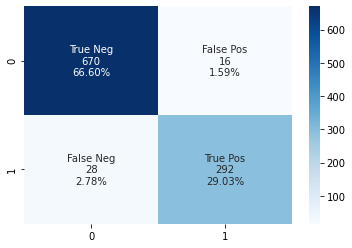

In [0]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                SVC_test_AAM.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     SVC_test_AAM.flatten()/np.sum(SVC_test_AAM)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(SVC_test_AAM, annot=labels, fmt="", cmap='Blues')

Out[41]: <matplotlib.axes._subplots.AxesSubplot at 0x7f3e3e35dbe0>

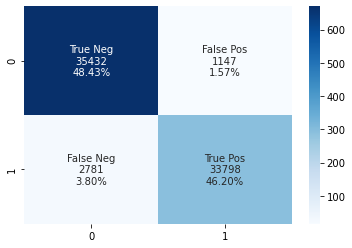

In [0]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                SVC_test_dflt.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     SVC_test_dflt.flatten()/np.sum(SVC_test_dflt)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(SVC_test_AAM, annot=labels, fmt="", cmap='Blues')

In [0]:
print("SVC with AAM test set ")
print(classification_report(testAAM_dataset.select("label").toPandas(), predictions_SVC_AAM.select("prediction").toPandas()))

SVC with AAM test set 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       686
           1       0.95      0.91      0.93       320

    accuracy                           0.96      1006
   macro avg       0.95      0.94      0.95      1006
weighted avg       0.96      0.96      0.96      1006



In [0]:
print("SVC with default test set ")
print(classification_report(test_dataset.select("label").toPandas(), predictions_SVC_default_test.select("prediction").toPandas()))

SVC with default test set 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     36579
           1       0.97      0.92      0.95     36579

    accuracy                           0.95     73158
   macro avg       0.95      0.95      0.95     73158
weighted avg       0.95      0.95      0.95     73158



In [0]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

paramGrid = ParamGridBuilder().addGrid(nl_classifier_rfc.maxDepth, [3, 6, 9, 11]).build()

In [0]:
tvs = TrainValidationSplit(
  estimator=rfc_model,
  estimatorParamMaps=paramGrid,
  evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction"),
  trainRatio=0.8)  # data is separated by 80% and 20%, in which the former is used for training and the latter for evaluation

model = tvs.fit(train_dataset)

/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation._MLFLOW_TRACKING_DISABLED_MESSAGE)


In [0]:
list(zip(model.validationMetrics, model.getEstimatorParamMaps()))

In [0]:
df10 = train_dataset.limit(15)
model.bestModel.transform(df10)\
  .select("Label", "prediction")\
  .show()

In [0]:
df10 = train_dataset.limit(15)
model.bestModel.transform(testAAM_dataset)\
  .select("Label", "prediction")\
  .show()

In [0]:
best_model_predic = model.bestModel.transform(testAAM_dataset)

In [0]:
evaluator3 = MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator3.evaluate(best_model_predic, {evaluator3.metricName: "accuracy"})))

In [0]:
# small, large = train_dataset.randomSplit([0.01, 0.99])

In [0]:
# nl_detector = svc_model.fit(small)
# nl_detector2 = svc_model.fit(train_dataset)

In [0]:
# predictions = nl_detector.transform(test_dataset)
# predictions.show(3)

In [0]:
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# evaluator = MulticlassClassificationEvaluator()
# print("Test Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))

In [0]:
# predictions.show()